In [1]:
# figure config
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

In [2]:
# import packages
from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from lmfit import Model, minimize, Parameters, fit_report
from lmfit.models import LinearModel

import os
import warnings
warnings.filterwarnings('ignore')

"""
"""

# path joining version for other paths
notebook_path = os.path.abspath('h2_map_stack.ipynb' + "/../")
filepath = os.path.join(os.path.dirname(notebook_path), 'spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# set fits index to begin and end
index0 = 22 
index1 = 112

# load fits data
order36_data_list = []
order32_data_list = []

for i in range(filesize):
    n = i + index0
    if n>= index0 and n < 10:
        hdu_data_order36 = fits.getdata(filepath + 'order36/new_frame/jun02s000' + '{}_order36.fits'.format(n), ext=0)
        order36_data_list.append(hdu_data_order36)
        hdu_data_order32 = fits.getdata(filepath + 'order32/new_frame/jun02s000' + '{}_order32.fits'.format(n), ext=0)
        order32_data_list.append(hdu_data_order32)
    elif n>= 10 and n < 100:
        hdu_data_order36 = fits.getdata(filepath + 'order36/new_frame/jun02s00' + '{}_order36.fits'.format(n), ext=0)
        order36_data_list.append(hdu_data_order36)
        hdu_data_order32 = fits.getdata(filepath + 'order32/new_frame/jun02s00' + '{}_order32.fits'.format(n), ext=0)
        order32_data_list.append(hdu_data_order32)
    elif n >= 100 and n < index1:
        hdu_data_order36 = fits.getdata(filepath + 'order36/new_frame/jun02s0' + '{}_order36.fits'.format(n), ext=0)
        order36_data_list.append(hdu_data_order36)
        hdu_data_order32 = fits.getdata(filepath + 'order32/new_frame/jun02s0' + '{}_order32.fits'.format(n), ext=0)
        order32_data_list.append(hdu_data_order32)
    elif n >= index1:
        break
order36_data = np.array(order36_data_list)
order32_data = np.array(order32_data_list)

# load waverange
waverange36 = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange32 = fits.open(filepath + 'order32/' + 'waverange.fits', ignore_missing_end=True)[0].data

# load spectral resolution
R36 = 73194.84858495607
R32 = 72803.45487481622
R = np.mean((R36,R32))

# obtain average flat field
avg_flat_order36 = np.mean((order36_data[32-index0], 
                              order36_data[33-index0], 
                              order36_data[34-index0], 
                              order36_data[35-index0], 
                              order36_data[36-index0], 
                              order36_data[37-index0], 
                              order36_data[38-index0], 
                              order36_data[39-index0], 
                              order36_data[40-index0], 
                              order36_data[41-index0],), axis=0)

avg_flat_order32 = np.mean((order32_data[32-index0], 
                              order32_data[33-index0], 
                              order32_data[34-index0], 
                              order32_data[35-index0], 
                              order32_data[36-index0], 
                              order32_data[37-index0], 
                              order32_data[38-index0], 
                              order32_data[39-index0], 
                              order32_data[40-index0], 
                              order32_data[41-index0],), axis=0)

# obtain average flat lamp off
avg_dark_order36 = np.mean((order36_data[22-index0], 
                                 order36_data[23-index0], 
                                 order36_data[24-index0],
                                 order36_data[25-index0], 
                                 order36_data[26-index0], 
                                 order36_data[27-index0], 
                                 order36_data[28-index0], 
                                 order36_data[29-index0], 
                                 order36_data[30-index0], 
                                 order36_data[31-index0],), axis=0)

avg_dark_order32 = np.mean((order32_data[22-index0], 
                                 order32_data[23-index0], 
                                 order32_data[24-index0],
                                 order32_data[25-index0], 
                                 order32_data[26-index0], 
                                 order32_data[27-index0], 
                                 order32_data[28-index0], 
                                 order32_data[29-index0], 
                                 order32_data[30-index0], 
                                 order32_data[31-index0],), axis=0)

# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= index0 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < index1:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= index1:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(data, fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = data[fn_sky1-index0]
    sky2 = data[fn_sky2-index0]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

# reduce fits for different orders and collect
# order36
spec36_reducelist = []

for i in range(60, 104):
    sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)
    
    if i in sky_frame:
        continue
    elif i not in sky_frame:
        skyframe36 = scale_sky_frame(order36_data, i)
    
        reduce_spec36 = (order36_data[i-index0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
    
        spec36_reducelist.append(reduce_spec36)
spec36_reduced = np.array(spec36_reducelist)
spec36_stacked = np.sum((spec36_reduced), axis=0)

# order32
spec32_reducelist = []

for i in range(60, 104):
    sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)
    
    if i in sky_frame:
        continue
    elif i not in sky_frame:
        skyframe32 = scale_sky_frame(order32_data, i)
    
        reduce_spec32 = (order32_data[i-index0] - skyframe32) / (avg_flat_order32 - avg_dark_order32)
        reduce_spec32[reduce_spec32<0] = 0
        reduce_spec32 = np.vstack((reduce_spec32, np.zeros((9, 1024))))
    
        spec32_reducelist.append(reduce_spec32)
spec32_reduced = np.array(spec32_reducelist)
spec32_stacked = np.sum((spec32_reduced), axis=0)

# load and reduce star spectra
modeA36 = order36_data[43-index0] + order36_data[46-index0] +\
        order36_data[47-index0] + order36_data[50-index0]
modeB36 = order36_data[44-index0] + order36_data[45-index0] +\
        order36_data[48-index0] + order36_data[49-index0]
modeA32 = order32_data[43-index0] + order32_data[46-index0] +\
        order32_data[47-index0] + order32_data[50-index0]
modeB32 = order32_data[44-index0] + order32_data[45-index0] +\
        order32_data[48-index0] + order32_data[49-index0]

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star
modeAB32 = ((modeA32 - modeB32)/4)/(avg_flat_order32 - avg_dark_order32)/exp_star
modeAB32 = np.vstack((modeAB32, np.zeros((9, 1024))))

# compute star spectra
flux36_model = Model(gaussian_fit)
flux32_model = Model(gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.005, min=0, max=0.05)
flux36_params.add('a1', value=71, min=68, max=74)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

flux32_params = flux32_model.make_params()
flux32_params.add('a0', value=0.004, min=0, max=0.05)
flux32_params.add('a1', value=68, min=65, max=71)
flux32_params.add('a2', value=2, min=0.5, max=5)
flux32_params.add('a3', value=0)
flux32_params.add('a4', value=0)
flux32_params.add('a5', value=0)

lower = 0
upper = 1024

spat_axis = np.linspace(0,263,264)

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))
star32_a0 = np.zeros(np.size(modeAB32,1))
star32_a2 = np.zeros(np.size(modeAB32,1))

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_axis)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
    try:
        flux32_fit_result = flux32_model.fit(modeAB32.T[i], flux32_params, x=spat_axis)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order32')
#     plt.figure()
#     plt.title('i='+str(i))
#     plt.plot(spat_axis, modeAB36.T[i])
#     plt.plot(spat_axis, flux36_fit_result.best_fit, 'r-', label='best fit')
    
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    star32_a0[i] = flux32_fit_result.params['a0'].value
    star32_a2[i] = flux32_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10
m_lambda = 6.787 # Kmag HD 109840
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))
Fbb32 = F_a0 * ((lambda_aw/waverange32)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange32*T)) - 1))

star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm
star32_fwhm = star32_a2*(np.sqrt(2*np.log(2))*2)
Fobs32 = star32_a0 * star32_fwhm

Fc36 = Fbb36/Fobs36
Fc32 = Fbb32/Fobs32

width = np.size(spec36_reduced, axis=1)
length = np.size(spec36_reduced, axis=2)

slit_area36 = 0.1*width*2.908e-5*length
slit_area32 = 0.1*width*3.304e-5*length
exp_spec = 10*6

# perform flux calibration
fjc36_list = []
fjc32_list = []

for i in range(np.size(spec36_reduced, axis=0)):    
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    fjc32_list.append(spec32_reduced[i] / exp_spec * Fc32 * 4.2535e10 / slit_area32)
fjc36 = np.array(fjc36_list)
fjc32 = np.array(fjc32_list)

# smooth along temporal axis
# stack_list36 = []
# stack_list32 = []
# for i in range(np.size(fjc36, axis=0)-1):
#     if i != 15:
#         stack_list36.append(np.sum((fjc36[i], fjc36[i+1]), axis=0))
#         stack_list32.append(np.sum((fjc32[i], fjc32[i+1]), axis=0))
    
# spec36_coadd = np.array(stack_list36)
# spec32_coadd = np.array(stack_list32)

# smooth along wavelength axis
st_list = []
# smooth = []
for i in range(np.size(fjc36, axis=0)):
    s1a = np.delete(fjc36[i], np.s_[116:], 1)
    s1b = np.delete(s1a, np.s_[:76], 1)
    s1b = scipy.ndimage.shift(s1b, 0.290495, order=3, mode='nearest')

    s2a = np.delete(fjc32[i], np.s_[759:], 1)
    s2b = np.delete(s2a, np.s_[:719], 1)
    s2b = scipy.ndimage.shift(s2b, -0.070032, order=3, mode='nearest')

    s3a = np.delete(fjc32[i], np.s_[968:], 1)
    s3b = np.delete(s3a, np.s_[:928], 1)
    s3b = scipy.ndimage.shift(s3b, 0.482580, order=3, mode='nearest')
    
    stt = s1b+s2b+s3b

# smooth along spatial axis
#     smoo = []
#     for j in range(2, len(stt)-2):
#         addup = np.mean((stt[j-2],stt[j-1],stt[j],stt[j+1],stt[j+2]), axis=0)
#         smoo.append(addup)
#         smoo[j] = addup
#     smooth = np.array(smoo)
    
    st_list.append(stt)
st = np.array(st_list)

In [3]:
# extract H2 properties by fitting gaussian curve to the emission lines
h2_a0_map = []
h2_a1_map = []
h2_fwhm_map = []
h2_a0_map_error = []
h2_a1_map_error = []
h2_fwhm_map_error = []

fn0 = 0
fn1 = np.size(st,0)

upper_h2 = 245
lower_h2 = 10

print('H2 LOOP START')
for fn in range(fn0, fn1):
    print('Frame Number = ' + str(fn))

    h2_a0 = np.zeros(300)
    h2_a1 = np.zeros(300)
    h2_a2 = np.zeros(300)
    h2_a0_error = np.zeros(300)
    h2_a1_error = np.zeros(300)
    h2_a2_error = np.zeros(300)
    
    stack = st[fn]
    
    pixel = np.linspace(0, np.size(stack,1)-1, np.size(stack,1))
    
    for i in range(lower_h2, upper_h2):
        # create lmfit model with defined gaussian
        h2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        h2_params = h2_model.make_params()
        h2_params.add('a0', value=0.06, min=0, max=0.1)
        h2_params.add('a1', value=20, min=17, max=23)
        h2_params.add('a2', value=2, min=0, max=6)
        h2_params.add('a3', value=0)
        h2_params.add('a4', value=0)
        h2_params.add('a5', value=0)
        
        # perform gaussian fit and test system errors
        try:
            h2_fit_result = h2_model.fit(stack[i], h2_params, x=pixel)
        except ValueError:
            print('ValueError occured at i=' + str(i))
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, stack[i])
            plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
        
        # collect fitting parameters
        h2_a0[i] = h2_fit_result.params['a0'].value
        h2_a1[i] = h2_fit_result.params['a1'].value
        h2_a2[i] = h2_fit_result.params['a2'].value
        h2_a0_error[i] = h2_fit_result.params['a0'].stderr
        h2_a1_error[i] = h2_fit_result.params['a1'].stderr
        h2_a2_error[i] = h2_fit_result.params['a2'].stderr
        
    # collect fitting parameters of each frame number and calibrate errors
    h2_a0_map.append(h2_a0)
    h2_a1_map.append(h2_a1)
    h2_fwhm_map.append(h2_a2 * (np.sqrt(2*np.log(2))*2))
    
    h2_a0_error[h2_a0_error > 10] = 1e10
    h2_a0_error[np.isnan(h2_a0_error)] = 1e10
    h2_a0_map_error.append(h2_a0_error)
    
    
    h2_a1_error[h2_a1_error > 10] = 1e10
    h2_a1_error[np.isnan(h2_a1_error)] = 1e10
    h2_a1_map_error.append(h2_a1_error)
    
    h2_a2_error[h2_a2_error > 10] = 1e10
    h2_a2_error[np.isnan(h2_a2_error)] = 1e10  
    h2_fwhm_map_error.append(h2_a2_error * (np.sqrt(2*np.log(2))*2))
    
print('DONE')

H2 LOOP START
Frame Number = 0
Frame Number = 1
Frame Number = 2
Frame Number = 3
Frame Number = 4
Frame Number = 5
Frame Number = 6
Frame Number = 7
Frame Number = 8
Frame Number = 9
Frame Number = 10
Frame Number = 11
Frame Number = 12
Frame Number = 13
Frame Number = 14
Frame Number = 15
Frame Number = 16
Frame Number = 17
Frame Number = 18
Frame Number = 19
Frame Number = 20
Frame Number = 21
Frame Number = 22
Frame Number = 23
Frame Number = 24
Frame Number = 25
Frame Number = 26
Frame Number = 27
Frame Number = 28
Frame Number = 29
Frame Number = 30
Frame Number = 31
Frame Number = 32
Frame Number = 33
Frame Number = 34
Frame Number = 35
Frame Number = 36
Frame Number = 37
DONE


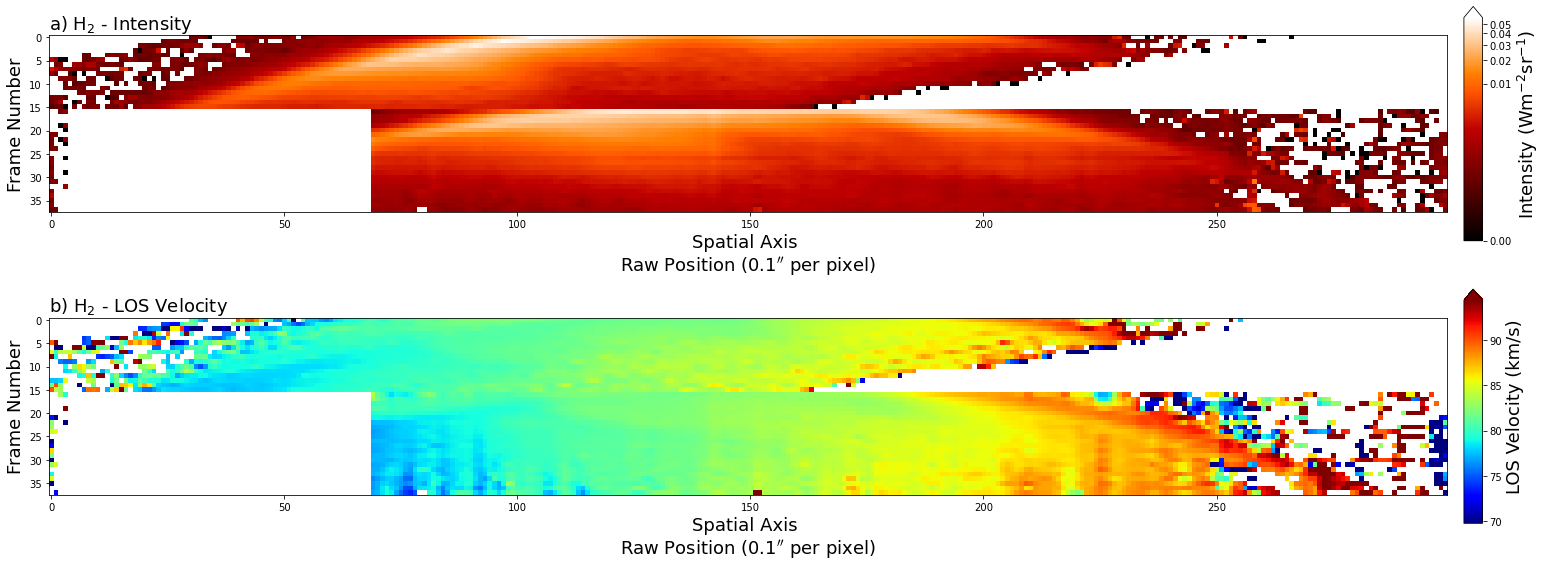

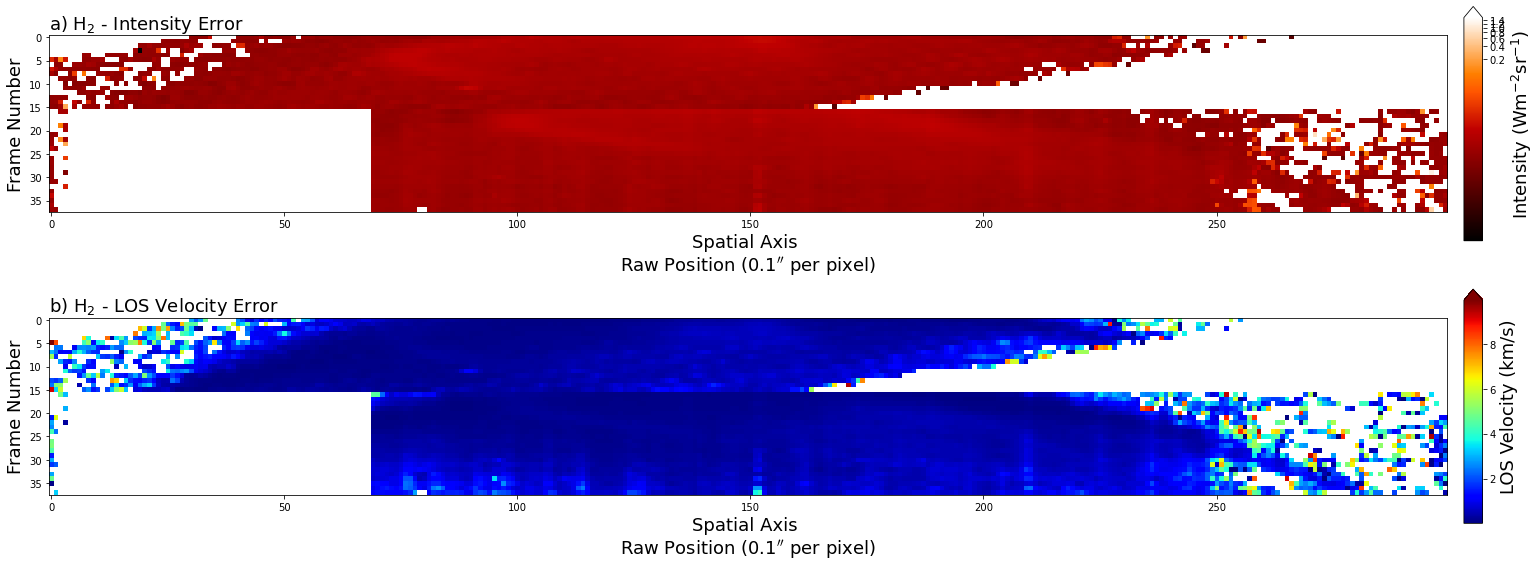

In [29]:
# data
h2_a0 = np.vstack((h2_a0_map))
h2_a1 = np.vstack((h2_a1_map))
h2_fwhm = np.vstack((h2_fwhm_map))

h2_int = h2_a0*h2_fwhm
h2_los = h2_a1/R*3e5*np.cos(3.098*np.pi/180)

h2_int1 = np.roll(h2_int[:6], 25, axis=1)
h2_int2 = np.roll(h2_int[6:11], 24, axis=1)
h2_int3 = np.roll(h2_int[11:16], 33, axis=1)
h2_int4 = np.roll(h2_int[16:27], -14, axis=1)
h2_int5 = np.roll(h2_int[27:], -14, axis=1)
h2_int_shifted = np.vstack((h2_int1, h2_int2, h2_int3, h2_int4, h2_int5))

for i in range(16):
    h2_int_shifted[i,:] = scipy.ndimage.shift(h2_int_shifted[i,:], i*6, order=3)

h2_los1 = np.roll(h2_los[:6], 25, axis=1)
h2_los2 = np.roll(h2_los[6:11], 24, axis=1)
h2_los3 = np.roll(h2_los[11:16], 33, axis=1)
h2_los4 = np.roll(h2_los[16:27], -14, axis=1)
h2_los5 = np.roll(h2_los[27:], -14, axis=1)
h2_los_shifted = np.vstack((h2_los1, h2_los2, h2_los3, h2_los4, h2_los5))

for i in range(16):
    h2_los_shifted[i,:] = scipy.ndimage.shift(h2_los_shifted[i,:], i*6, order=3)

h2_int_shifted = np.flip(h2_int_shifted, 1)
h2_los_shifted = np.flip(h2_los_shifted, 1)


# error
h2_a0_error = np.vstack((h2_a0_map_error))
h2_a1_error = np.vstack((h2_a1_map_error))
h2_fwhm_error = np.vstack((h2_fwhm_map_error))

h2_a0_error[h2_a0_error==0]=1e10
h2_a1_error[h2_a1_error==0]=1e10
h2_fwhm_error[h2_fwhm_error==0]=1e10

h2_a0[h2_a0==0]=1e10
h2_a1[h2_a1==0]=1e10
h2_fwhm[h2_fwhm==0]=1e10

h2_int_error = h2_int*np.sqrt((h2_a0_error/h2_a0)**2+(h2_fwhm_error/h2_fwhm)**2)
h2_los_error = h2_a1_error/R*3e5*np.cos(3.098*np.pi/180)

h2_int1_error = np.roll(h2_int_error[:6], 25, axis=1)
h2_int2_error = np.roll(h2_int_error[6:11], 24, axis=1)
h2_int3_error = np.roll(h2_int_error[11:16], 33, axis=1)
h2_int4_error = np.roll(h2_int_error[16:27], -14, axis=1)
h2_int5_error = np.roll(h2_int_error[27:], -14, axis=1)
h2_int_shifted_error = np.vstack((h2_int1_error, h2_int2_error, h2_int3_error, h2_int4_error, h2_int5_error))

for i in range(16):
    h2_int_shifted_error[i,:] = scipy.ndimage.shift(h2_int_shifted_error[i,:], i*6, order=3)

h2_los1_error = np.roll(h2_los_error[:6], 25, axis=1)
h2_los2_error = np.roll(h2_los_error[6:11], 24, axis=1)
h2_los3_error = np.roll(h2_los_error[11:16], 33, axis=1)
h2_los4_error = np.roll(h2_los_error[16:27], -14, axis=1)
h2_los5_error = np.roll(h2_los_error[27:], -14, axis=1)
h2_los_shifted_error = np.vstack((h2_los1_error, h2_los2_error, h2_los3_error, h2_los4_error, h2_los5_error))

for i in range(16):
    h2_los_shifted_error[i,:] = scipy.ndimage.shift(h2_los_shifted_error[i,:], i*6, order=3)
    
h2_int_shifted_error[h2_int_shifted_error>=10] = np.nan
h2_int_shifted_error[h2_int_shifted_error<=1e-6] = np.nan
h2_los_shifted_error[h2_los_shifted_error>=10] = np.nan
h2_los_shifted_error[h2_los_shifted_error<=1e-6] = np.nan

h2_int_shifted_error = np.flip(h2_int_shifted_error, 1)
h2_los_shifted_error = np.flip(h2_los_shifted_error, 1)

h2_int_shifted[np.isnan(h2_int_shifted_error)] = np.nan
h2_los_shifted[np.isnan(h2_los_shifted_error)] = np.nan


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_shifted, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
# colMap = cm.gist_heat
# colMap.set_bad(color='white')
plt.imshow(h2_int_shifted_error, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

0.11981140339526057


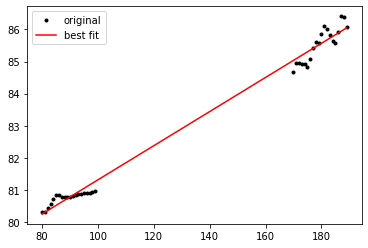

In [54]:
# subtract velocity at center of planet
# top half [:16]
crop1a = np.delete(h2_los_shifted[3:6], np.s_[100:], axis=1)
crop1b = np.delete(crop1a, np.s_[:80], axis=1)
crop2a = np.delete(h2_los_shifted[7:10], np.s_[190:], axis=1)
crop2b = np.delete(crop2a, np.s_[:170], axis=1)

# plt.figure(figsize=(10,5))
# plt.imshow(crop1b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

# plt.figure(figsize=(10,5))
# plt.imshow(crop2b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

avg_crop1b = np.mean(crop1b, axis=0)
avg_crop2b = np.mean(crop2b, axis=0)
line1 = np.linspace(80,99,20)
line2 = np.linspace(170,189,20)

line_tot = np.concatenate((line1,line2))
avg_crop_tot = np.concatenate((avg_crop1b, avg_crop2b))

# best fit line
mod = LinearModel()

pars_crop = mod.guess(avg_crop_tot, x=line_tot)
out_crop = mod.fit(avg_crop_tot, pars_crop, x=line_tot)

# print(out.fit_report(min_correl=0.25))

m = out_crop.params['slope'].value
y0 = out_crop.params['intercept'].value
sig_m = out_crop.params['slope'].stderr
sig_y0 = out_crop.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
x_fit = np.linspace(80,189,110)
avg_crop_best_fit = m * x_fit + y0
avg_crop_error = np.sqrt(sig_m**2 + sig_y0**2)
print(avg_crop_error)

plt.figure()
plt.plot(line_tot, avg_crop_tot,'.k', label = 'original')
plt.plot(x_fit, avg_crop_best_fit, 'r', label = 'best fit')
plt.legend()

0.15589215558030464


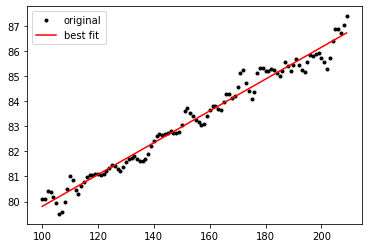

In [55]:
# bottom half [16:]
box1a = np.delete(h2_los_shifted[30:35], np.s_[210:], axis=1)
box2a = np.delete(box1a, np.s_[:100], axis=1)

# plt.figure(figsize=(10,5))
# plt.imshow(box, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

avg_box = np.mean(box2a, axis=0)

x_axis = np.linspace(100,209,110)

mod = LinearModel()

pars_box = mod.guess(avg_box, x=x_axis)
out_box = mod.fit(avg_box, pars_box, x=x_axis)

# print(out.fit_report(min_correl=0.25))

k = out_box.params['slope'].value
b = out_box.params['intercept'].value
sig_k = out_box.params['slope'].stderr
sig_b = out_box.params['intercept'].stderr

avg_box_best_fit = k * x_axis + b
avg_box_error = np.sqrt(sig_k**2 + sig_b**2)
print(avg_box_error)

plt.figure()
plt.plot(x_axis, avg_box,'.k', label = 'original')
# np.savetxt('h2_box.txt', avg_box)
plt.plot(x_axis, avg_box_best_fit, 'r', label = 'best fit')
plt.legend()

In [74]:
avg_crop_best_fit[np.where(x_fit==150)][0]

83.97360503088187

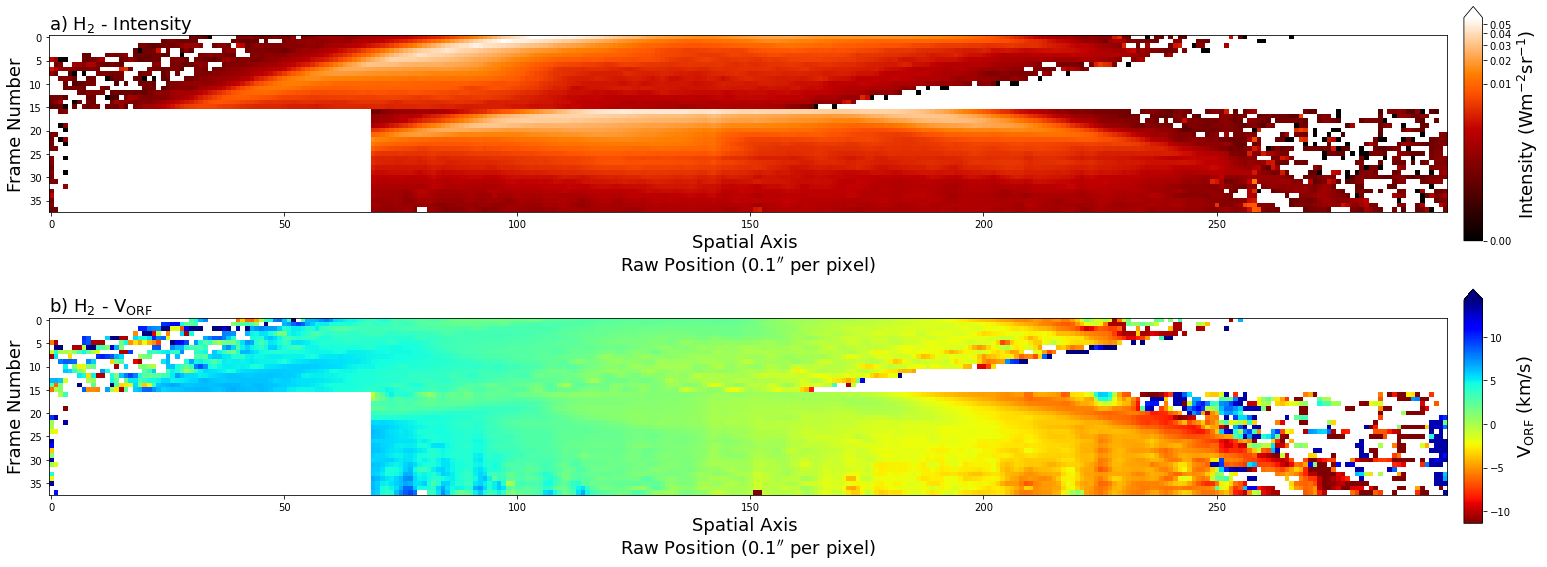

In [56]:
h2_los_shifted_sec1 = np.delete(h2_los_shifted, np.s_[16:], axis=0)
h2_los_shifted_sec2 = np.delete(h2_los_shifted, np.s_[:16], axis=0)

h2_los_rel_sec1 = h2_los_shifted_sec1 - avg_crop_best_fit[np.where(x_fit==150)][0]
h2_los_rel_sec2 = h2_los_shifted_sec2 - avg_box_best_fit[np.where(x_axis==150)][0]

h2_los_rel = np.vstack((h2_los_rel_sec1, h2_los_rel_sec2))

# h2_int_shifted[np.isnan(h2_int_shifted_error)] = np.nan
# h2_los_rel[np.isnan(h2_los_shifted_error)] = np.nan
# h2_los_rel[h2_los_rel>=6] = 6
# h2_los_rel[h2_los_rel<=-6] = -6


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_rel*(-1), cmap='jet_r')
# plt.imshow(h2_los_rel, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - V$_{\mathrm{ORF}}$', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{ORF}}$ (km/s)',size=18)

In [57]:
avg_crop_best_fit[np.where(x_fit==150)][0]

83.97360503088187

In [58]:
avg_box_best_fit[np.where(x_axis==150)][0]

82.97593663879954

In [59]:
avg_crop_best_fit[np.where(x_fit==150)][0] - avg_box_best_fit[np.where(x_axis==149)][0]

1.0609962473605066

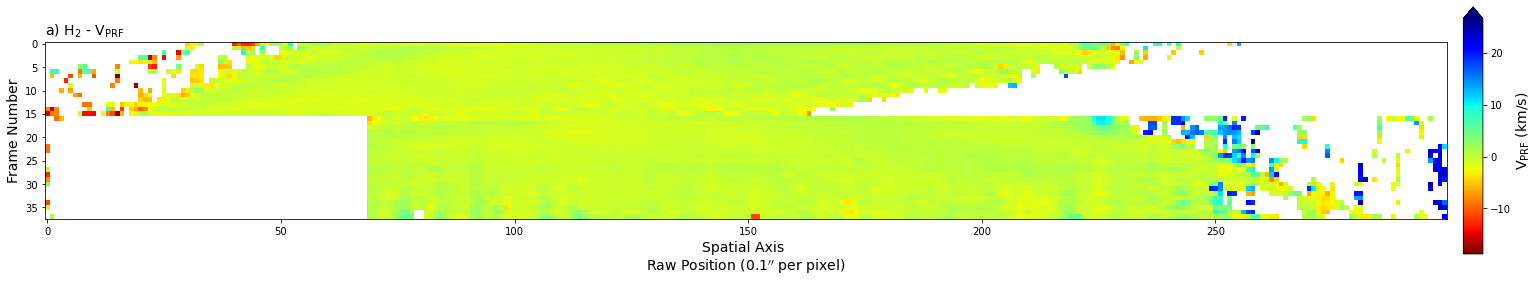

In [61]:
ang_diam = 40.58867
ang_diam/(0.1)
limb_vel = 12.572
vel_slope = limb_vel * 2 / (ang_diam/(0.1))

x = np.linspace(0,299,300)
rot_rate = vel_slope * x
rot_rate = rot_rate - rot_rate[150]

h2_plan_vel = h2_los_rel + 0

for i in range(np.size(h2_los_rel, 0)):
    h2_plan_vel[i,:] = h2_los_rel[i,:] - rot_rate


spatial_velocity = h2_los_rel + 0
spatial_velocity[::] = 0

for i in range(np.size(spatial_velocity, 1)):
    for j in range(1, np.size(spatial_velocity, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            p = np.array((h2_int_shifted[j-1][i], h2_int_shifted[j][i], h2_int_shifted[j+1][i]))
#             print(j,i)
#             plt.figure()
#             plt.plot(y, p, 'k.', label='original')
            f = scipy.interpolate.interp1d(y,p)
            xnew = np.linspace(0,2,7)
#             plt.figure()
#             plt.plot(xnew, f(xnew), 'r.', label='interpolate')
#             plt.legend()
#             print(f(xnew[2]), f(xnew[4]))
            p1 = f(xnew[2])
            p3 = f(xnew[4])
            di = (p3 - p1)/(p3 + p1)
            dv = 7.6*di
            
            if np.isreal(dv):
                spatial_velocity[j,i] = dv
                
spatial_velocity2 = spatial_velocity + 0
spatial_velocity2[np.isnan(h2_int_shifted_error)] = np.nan
spatial_velocity2[spatial_velocity <= 1.5] = np.nan

h2_plan_vel2 = h2_plan_vel + 0
h2_plan_vel2[h2_plan_vel2 < -1] = np.nan
h2_plan_vel2[h2_plan_vel2 > 5] = np.nan
h2_plan_vel2[h2_los_shifted_error > 1] = np.nan
h2_plan_vel2[np.isnan(spatial_velocity2)] = np.nan

# spatial_velocity2[np.isnan(h2_plan_vel2)] = np.nan

# a = spatial_velocity2[np.isfinite(spatial_velocity2)]
# b = h2_plan_vel2[np.isfinite(h2_plan_vel2)]

# print(10/(np.mean(a[60:220])/np.mean(b[60:220])))

# # spatial_velocity.shape
# plt.figure()
# plt.plot(a, 'k--')
# plt.plot(b, 'r-')

h2_corrected_vel = h2_plan_vel - spatial_velocity
# h2_corrected_vel[h2_corrected_vel > 2] = 2
# h2_corrected_vel[h2_corrected_vel < -2] = -2

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(h2_corrected_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_2$ - V$_{\mathrm{PRF}}$', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

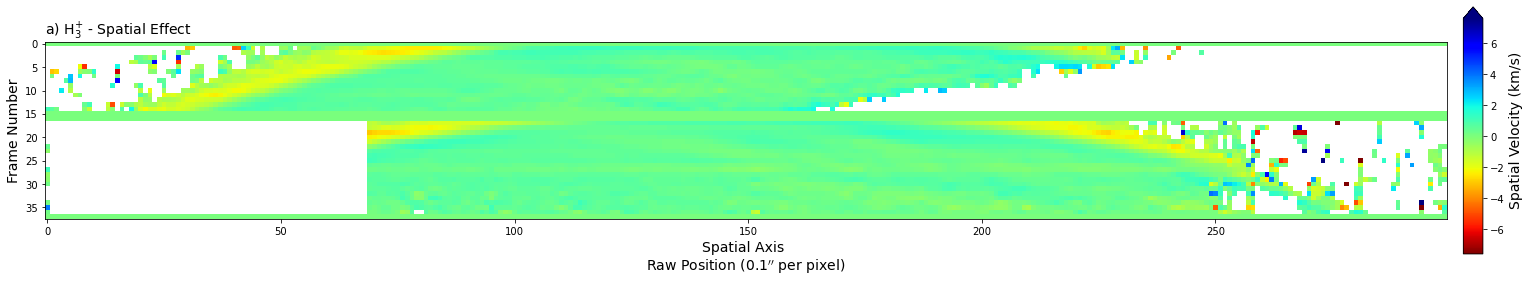

In [62]:
fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(spatial_velocity*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

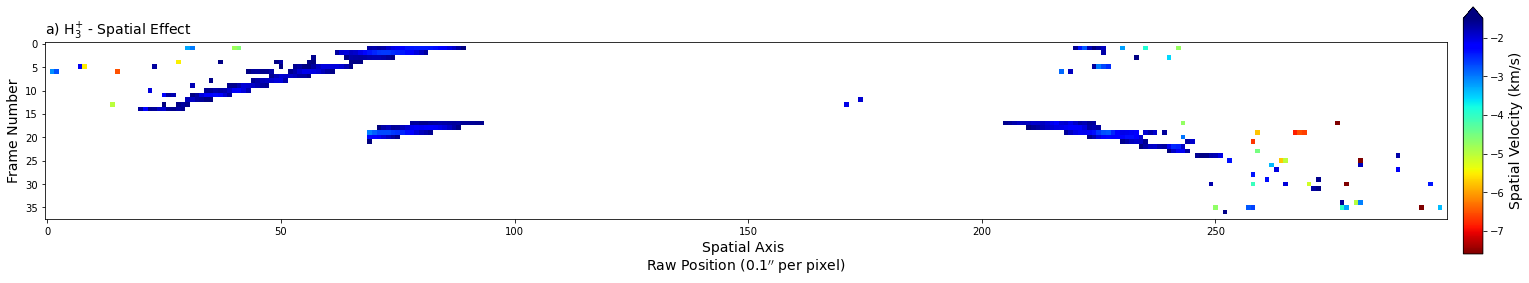

In [63]:
fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(spatial_velocity2*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

In [73]:
crop3a = np.delete(spatial_velocity2[3:6], np.s_[220:], axis=1)
crop3b = np.delete(crop3a, np.s_[:200], axis=1)
crop4a = np.delete(spatial_velocity2[7:10], np.s_[120:], axis=1)
crop4b = np.delete(crop4a, np.s_[:100], axis=1)
crop4b

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]])

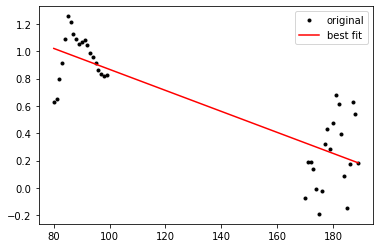

In [65]:
crop3a = np.delete(h2_corrected_vel[3:6], np.s_[100:], axis=1)
crop3b = np.delete(crop3a, np.s_[:80], axis=1)
crop4a = np.delete(h2_corrected_vel[7:10], np.s_[190:], axis=1)
crop4b = np.delete(crop4a, np.s_[:170], axis=1)

# plt.figure(figsize=(10,5))
# plt.imshow(crop3b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))
# plt.figure(figsize=(10,5))
# plt.imshow(crop4b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

avg_crop3b = np.mean(crop3b, axis=0)
avg_crop4b = np.mean(crop4b, axis=0)
line3 = np.linspace(80, 99,20)
line4 = np.linspace(170,189,20)
# line3 = np.arange(80,100)
# line4 = np.arange(170,190)

line_tot2 = np.concatenate((line3,line4))
avg_crop_tot2 = np.concatenate((avg_crop3b, avg_crop4b))

# best fit line
mod = LinearModel()

pars_crop2 = mod.guess(avg_crop_tot2, x=line_tot2)
out_crop2 = mod.fit(avg_crop_tot2, pars_crop2, x=line_tot2)

# print(out.fit_report(min_correl=0.25))

m2 = out_crop2.params['slope'].value
y02 = out_crop2.params['intercept'].value
sig_m2 = out_crop2.params['slope'].stderr
sig_y02 = out_crop2.params['intercept'].stderr

x_fit2 = np.linspace(80,189,110)
# x_fit2 = np.arange(80,190)
avg_crop2_fit = m2 * x_fit2 + y02
avg_crop2_error = np.sqrt(sig_m2**2 + sig_y02**2)

plt.figure()
plt.plot(line_tot2, avg_crop_tot2,'.k', label = 'original')
plt.plot(x_fit2, avg_crop2_fit, 'r', label = 'best fit')
plt.legend()

In [66]:
avg_crop2_error

0.11748337921174645

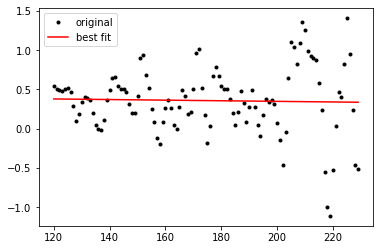

In [67]:
box3a = np.delete(h2_corrected_vel[30:35], np.s_[230:], axis=1)
box3b = np.delete(box3a, np.s_[:120], axis=1)

avg_box3b = np.mean(box3b, axis=0)

x_box3b = np.arange(120, 230)

mod = LinearModel()

pars_box3b = mod.guess(avg_box3b, x=x_box3b)
out_box3b = mod.fit(avg_box3b, pars_box3b, x=x_box3b)

# print(out.fit_report(min_correl=0.25))

k2 = out_box3b.params['slope'].value
b2 = out_box3b.params['intercept'].value
sig_k2 = out_box3b.params['slope'].stderr
sig_b2 = out_box3b.params['intercept'].stderr

avg_box3b_fit = k2 * x_box3b + b2
avg_box3b_error = np.sqrt(sig_k2**2 + sig_b2**2)

plt.figure()
plt.plot(x_box3b, avg_box3b,'.k', label = 'original')
# np.savetxt('h2_box.txt', avg_box)
plt.plot(x_box3b, avg_box3b_fit, 'r', label = 'best fit')
plt.legend()

In [68]:
avg_box3b_error

0.22954162286466917

In [75]:
print(avg_crop2_fit[np.where(x_fit2==150)][0])
print(avg_box3b_fit[np.where(x_box3b==150)][0])
print(avg_crop2_fit[np.where(x_fit2==150)][0] - avg_box3b_fit[np.where(x_box3b==150)][0])

0.483157552265177
0.3669433855501023
0.11621416671507467


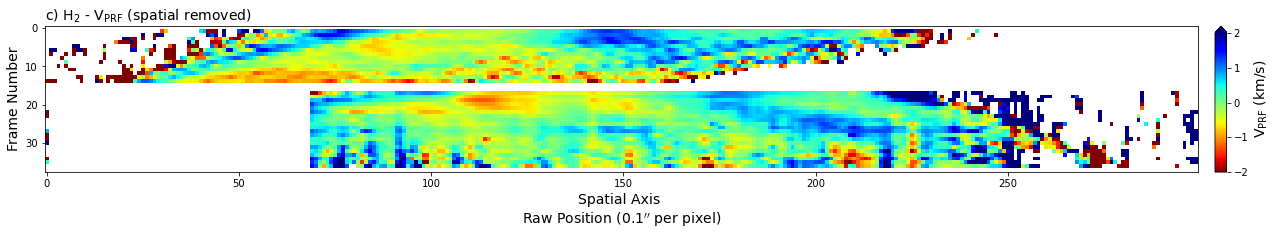

In [70]:
h2_corrected_vel_sec1 = np.delete(h2_corrected_vel, np.s_[16:], axis=0)
h2_corrected_vel_sec2 = np.delete(h2_corrected_vel, np.s_[:16], axis=0)

h2_vprf_sec1 = h2_corrected_vel_sec1 - avg_crop2_fit[np.where(x_fit2==150)][0]
# h2_vprf_sec2 = h2_corrected_vel_sec2 - h2_vel_best_fit2[np.where(x_axis2==149)][0]
h2_vprf_sec2 = h2_corrected_vel_sec2 - avg_box3b_fit[np.where(x_box3b==150)][0]

h2_vprf = np.vstack((h2_vprf_sec1, h2_vprf_sec2))
h2_vprf[h2_vprf > 2] = 2
h2_vprf[h2_vprf < -2] = -2
h2_vprf[0] = np.nan
h2_vprf[15] = np.nan
h2_vprf[16] = np.nan
h2_vprf[-1] = np.nan

fig = plt.figure(figsize=(24,8), tight_layout=True)

# fig.add_subplot(311)
# plt.imshow(spatial_velocity2*(-1), cmap='jet_r')
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
# plt.ylabel('Frame Number', fontsize=14)
# plt.title('a) H$_2$ - Spatial Effect', loc='left', fontsize=14)
# plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

# fig.add_subplot(312)
# plt.imshow(h2_plan_vel2*(-1), cmap='jet_r')
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
# plt.ylabel('Frame Number', fontsize=14)
# plt.title('b) H$_2$ - V$_{\mathrm{PRF}}$', loc='left', fontsize=14)
# plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

fig.add_subplot(313)
plt.imshow(h2_vprf*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_2$ - V$_{\mathrm{PRF}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

In [71]:
hdu1 = fits.PrimaryHDU(spatial_velocity2)
hdu1.writeto('h2_spatial_vel2.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h2_plan_vel2)
hdu2.writeto('h2_plan_vel2.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h2_vprf)
hdu3.writeto('h2_vprf.fits', overwrite=True)